# **NER AND SENTIMENT ANALYSIS ON AMAZON CELL PHONE REVIEWS**

## Library Imports and Dataset Loading

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import nltk
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
import os
from keras.callbacks import Callback
from keras import regularizers
import matplotlib.pyplot as plt
import numpy as np
from scikitplot.metrics import plot_confusion_matrix, plot_roc

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
df = pd.read_csv("/content/20191226-reviews.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67986 entries, 0 to 67985
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   asin          67986 non-null  object 
 1   name          67984 non-null  object 
 2   rating        67986 non-null  int64  
 3   date          67986 non-null  object 
 4   verified      67986 non-null  bool   
 5   title         67972 non-null  object 
 6   body          67965 non-null  object 
 7   helpfulVotes  27215 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(5)
memory usage: 3.7+ MB


In [6]:
#Taking a subset of the data with only required columns
df = df[['rating', 'body']]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67986 entries, 0 to 67985
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  67986 non-null  int64 
 1   body    67965 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [8]:
#Dropping all null values 
df = df.dropna()

## **Named Entity Recognition**

In [9]:
#function to get only ORGANIZATIONS detected from NER (to obtain brands)
def get_NER_org(x):
  ner_orgs = []
  doc = nlp(x)
  for ent in doc.ents:
      if (ent.label_ == 'ORG'):
        ner_orgs.append(ent.text.lower())
  return list(set(ner_orgs))

In [10]:
#Loading the English language spacy model for NER
nlp = en_core_web_sm.load()

In [11]:
#Applying the ORG filter function on the dataset
df['NER_brands'] = df.apply(lambda x: get_NER_org(x.body), axis=1)

In [12]:
#Calculating number of ORG detected for each row
df['NER_brand_count'] = df.apply(lambda x: len(x.NER_brands), axis=1)

In [13]:
df['NER_brands'][1345]

['microsoft', 'iphones']

In [14]:
print(len(df['NER_brands'][1345]))

2


In [15]:
#Filtering dataset to obtain records with only one NER ORG detected for future studies
df = df[(df.NER_brand_count == 1)]

In [16]:
df.reset_index(inplace=True)

In [17]:
#Exporting value counts as csv to see entire list of NER ORG detected
(df.NER_brands.value_counts()).to_csv('name.csv')

In [19]:
df['NER_brands'] = df['NER_brands'].apply(lambda x: ','.join(map(str, x)))

In [29]:
df['NER_brands'][185]

'samsung'

In [30]:
df['body'][185]

'We purchased this phone in September--delivered on September 19. Was working great until this past Saturday when we decided to "update" the phone as per the "update" messages on the phone. As soon as the updates were complete and the computer screen gave the OK to use the phone again, we turned it on and then the phone went crazy!!!! It kept turning itself on and off. We called Samsung directly and they had us hard boot the phone. After several attempts, the hard boot completed, but the problem was still the same. I know the description says no warranty, but if this is a "new phone" as advertised, I would think we should be able to get our money back (or replacement). Planning to call to selling company to see if that would be an option--if this truly was a "new phone", it should not have died after only six weeks of use. Very sad.'

In [31]:
#creating a subset of the data
data_final = df

In [32]:
#combining apple and iphones as one brand
data_final['NER_brands'] = data_final['NER_brands'].replace(['iphones'],'apple')

In [33]:
#filtering the dataset to obtain only some of the leading cell phone brands
brand_list = ["samsung", "android", "nokia", "sony", "apple", "huawei", "xiaomi"]
data_final = data_final[data_final['NER_brands'].isin(brand_list)]

In [34]:
data_final.NER_brands.value_counts()

samsung    1386
android     582
nokia       413
sony        381
apple       202
huawei      117
xiaomi       87
Name: NER_brands, dtype: int64

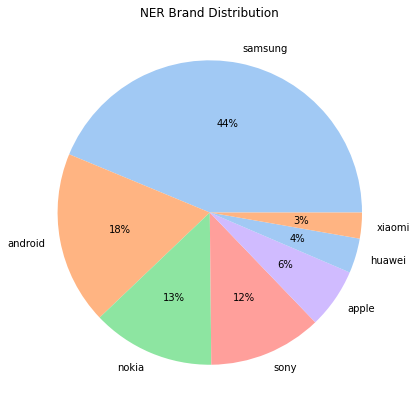

In [36]:
#Visualize the brand distribution as detected by NER
colors = sns.color_palette('pastel')[0:5] #define Seaborn color palette to use
plt.figure(figsize=(7,7))
plt.pie(data_final['NER_brands'].value_counts(), labels = data_final['NER_brands'].value_counts().index, colors = colors, autopct='%.0f%%')
plt.title("NER Brand Distribution")
plt.show()

## Data Pre-processing for NLP

In [37]:
#function to remove unwanted characters and convert all text to lower case
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

#function to remove emoticons, foreign characters and symbols
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

#function to obtain the part-of-speech of words in the text
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.VERB)

#function to lemmatize, remove stop words and tokenize the text
def lemmatize_text(description_):
    individual_word_list=[]
    lemmatizer = WordNetLemmatizer() 
    words = word_tokenize(description_)
    stop_words = stopwords.words('english')

    words_without_sw = [word for word in words if not word in stop_words]

    for word in words_without_sw:
      individual_word_list.append(lemmatizer.lemmatize(word, get_wordnet_pos(word)))
           
    return ' '.join(individual_word_list)

In [38]:
#apply the cleaning functions on the reviews text in the dataframe
data_final["body_cleaned"] = data_final["body"].apply(lambda x:clean_text(str(x)))
data_final["body_cleaned"] = data_final["body_cleaned"].apply(lambda x:remove_emoji(str(x)))
data_final['body_cleaned'] = data_final['body_cleaned'].apply(lemmatize_text)

In [39]:
#sample text after cleaning
data_final['body_cleaned'][0]

'great reliable phone also purchase phone samsung die menu easily comprehendable speed dial available around number voice dial also nice feature take longer speed dial thing bother gamesnokia seem take snake phone skydive game bowling tennis like pong ringer nice feature available choose different ringer person call however ringtones available online download phone youre pretty much stuck vibrate ringtones regular midi polyphonic tone need cover reasonable price range'

### Checking for data imbalance

In [40]:
data_final.rating.value_counts()

5    1596
1     649
4     420
2     254
3     249
Name: rating, dtype: int64

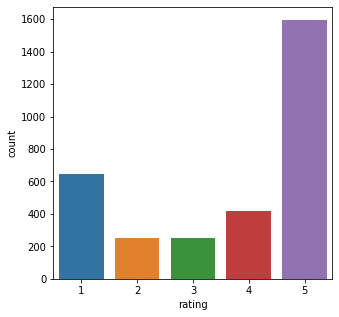

In [41]:
#Visualizing the distribution of the ratings
plt.figure(figsize=(5,5))
sns.countplot(data_final['rating'])
plt.show()

In [42]:
#Encoding the rating to a scale from 0 to 4 (required to apply class_weights from scikit to balance data) 
replace_dict = {1:0, 2:1, 3:2, 4:3, 5:4 }
data_final=data_final.replace({"rating": replace_dict})

### Splitting Dataset into Training , Validation and Testing

In [43]:
# Shuffle your dataset 
shuffle_df = data_final.sample(frac=1)

# Define a size for your train, val and test sets (70:10:20 respectively)
train_size = int(0.7* len(data_final))
val_size = int(0.1* len(data_final))
test_size = int(0.2* len(data_final))

# Split your dataset 
train_df = shuffle_df[:train_size]
val_df = shuffle_df[train_size:(train_size+val_size)]
test_df = shuffle_df[(train_size+val_size) : ]

In [44]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(2217, 6)
(635, 6)
(316, 6)


In [45]:
#Converting the respective feature and target columns to arrays
X_train = train_df['body_cleaned'].to_numpy()
y_train = train_df['rating'].to_numpy()
X_val = val_df['body_cleaned'].to_numpy()
y_val = val_df['rating'].to_numpy()
X_test = test_df['body_cleaned'].to_numpy()
y_test = test_df['rating'].to_numpy()

In [46]:
X_train

array(['bought ultra blue nice color havent found anything dont like absolutely best battery last phone galaxy year poor battery reason switch headphone jack quit work year also first sony phone im glad get',
       'phone could big opinion persistent samsung apps frustrate since continually want update even use fingerprint recognition frustrate sometimes battery life good screen sharp clear see even bright light condition',
       'solid phone love android one stock system simple fast', ...,
       'bought phone brand new last month usbc port stop work cant charge phone regular charger use wireless charger genius google want like apple decide away headphone jack cant even use headphone thanks make junk google never buy google pixel whatever model come',
       'yes like idea android one great earphone jack headset jack',
       'beautiful phone feel love samsung make great galaxy model phone'],
      dtype=object)

## Model Building

### Simple Tensorflow and Keras model with basic embedding

In [48]:
#Embedding using Google Universal Sentence Encoder
embedding = "https://tfhub.dev/google/universal-sentence-encoder/4"

In [49]:
#Creating the hub layer with the embedded data
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

In [64]:
#Defining the model architecture (layers)

model = keras.Sequential()
model.add(hub_layer) #embedding layer
model.add(keras.layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(8, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(5, activation='softmax'))

In [65]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_3 (Dense)             (None, 16)                8208      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 5)                 45        
                                                                 
Total params: 256,806,213
Trainable params: 256,806,21

In [66]:
#Compiling the model
#Optimizer - Adam
#Loss function - SparseCategoricalCrossentropy
#Metric - Accuracy
model.compile(optimizer='Adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['Accuracy'])

In [57]:
#Funtion to output a confusion matrix on validation data at each epoch
class PerformanceVisualizationCallback(Callback):    
    def __init__(self, model, validation_data, image_dir):
        super().__init__()
        self.model = model
        self.validation_data = validation_data
        
        os.makedirs(image_dir, exist_ok=True)
        self.image_dir = image_dir

    def on_epoch_end(self, epoch, logs={}):
        y_pred = np.asarray(self.model.predict(self.validation_data[0]))
        y_true = self.validation_data[1]             
        y_pred_class = np.argmax(y_pred, axis=1)

        # plot and save confusion matrix
        fig, ax = plt.subplots(figsize=(16,12))
        plot_confusion_matrix(y_true, y_pred_class, ax=ax)
        fig.savefig(os.path.join(self.image_dir, f'confusion_matrix_epoch_{epoch}'))

In [58]:
#Setting up the performance visualization functions
performance_cbk = PerformanceVisualizationCallback(
                      model=model,
                      validation_data=(X_val, y_val),
                      image_dir='performance_vizualizations')

In [59]:
#Balancing the data imbalance
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 1.0054421768707482,
 1: 2.3838709677419354,
 2: 2.592982456140351,
 3: 1.5133105802047782,
 4: 0.39378330373001774}

In [60]:
#Introducing Early Stopping to prevent overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

Epoch 1/20
70/70 [==============================] - 175s 2s/step - loss: 1.4593 - Accuracy: 0.4560 - val_loss: 1.3649 - val_Accuracy: 0.5823
Epoch 2/20
70/70 [==============================] - 174s 2s/step - loss: 1.2262 - Accuracy: 0.5968 - val_loss: 1.3658 - val_Accuracy: 0.5127
Epoch 3/20
70/70 [==============================] - 485s 7s/step - loss: 1.0661 - Accuracy: 0.6346 - val_loss: 1.3910 - val_Accuracy: 0.4873
Epoch 4/20
70/70 [==============================] - 798s 11s/step - loss: 0.9960 - Accuracy: 0.6428 - val_loss: 1.3568 - val_Accuracy: 0.5190
Epoch 5/20
70/70 [==============================] - 798s 11s/step - loss: 0.9254 - Accuracy: 0.6446 - val_loss: 1.4735 - val_Accuracy: 0.5127
Epoch 6/20
70/70 [==============================] - 798s 11s/step - loss: 0.8858 - Accuracy: 0.6617 - val_loss: 1.3428 - val_Accuracy: 0.4494
Epoch 7/20
70/70 [==============================] - 800s 11s/step - loss: 0.8659 - Accuracy: 0.6613 - val_loss: 1.3177 - val_Accuracy: 0.5728
Epoch 8/2

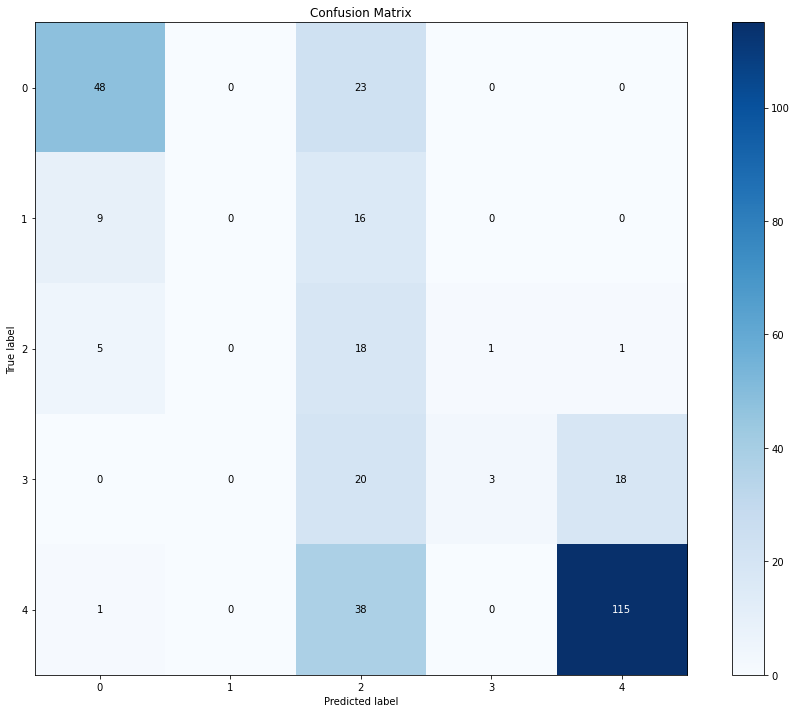

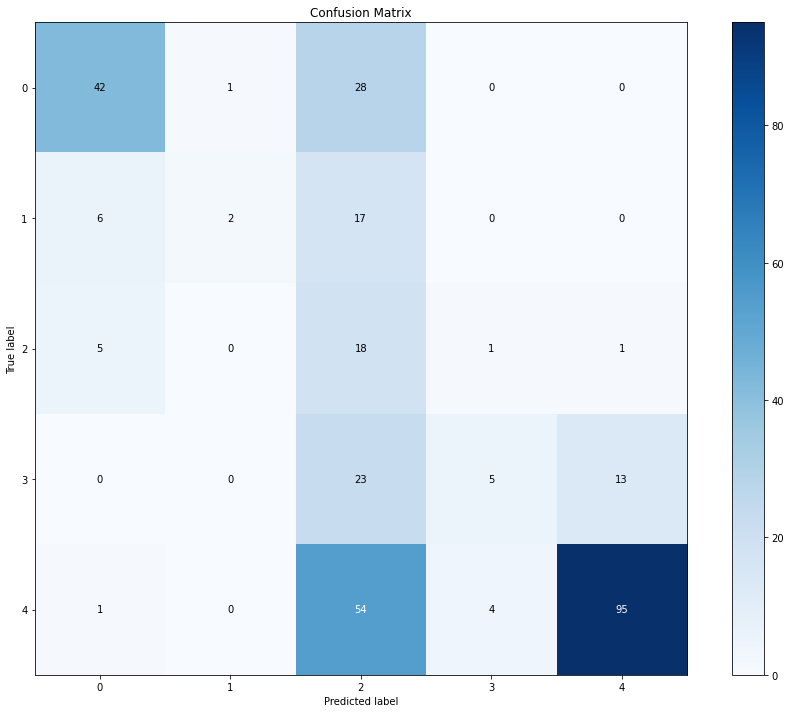

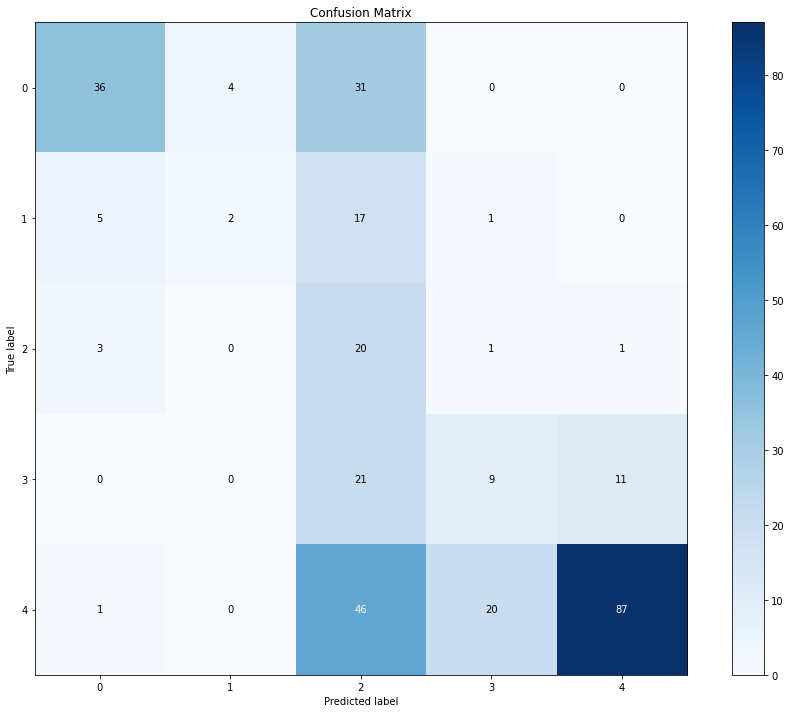

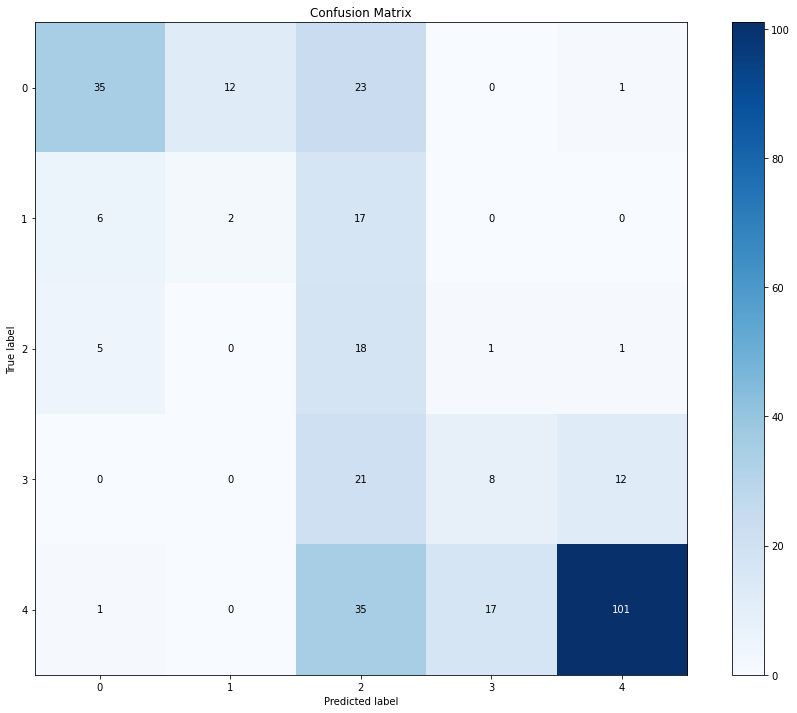

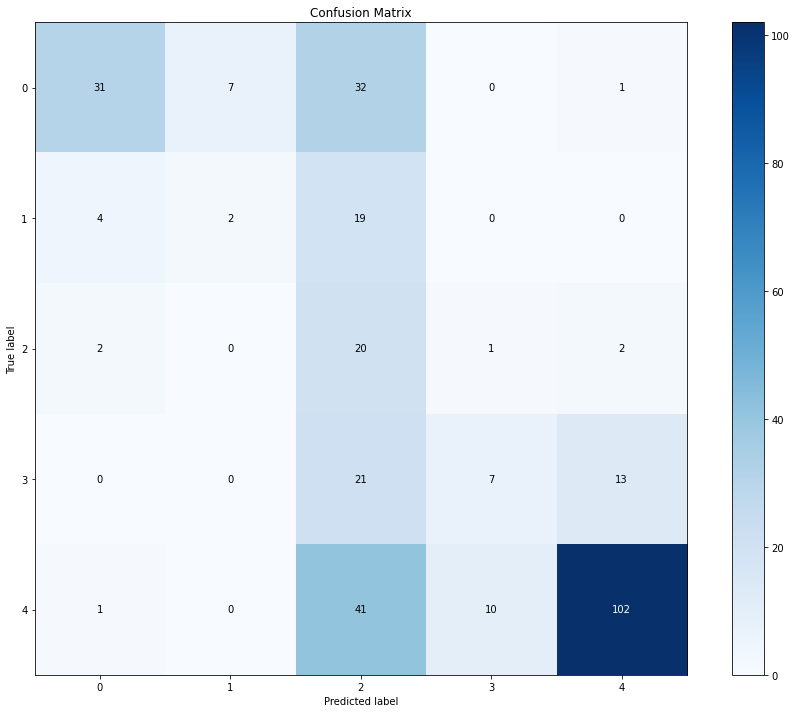

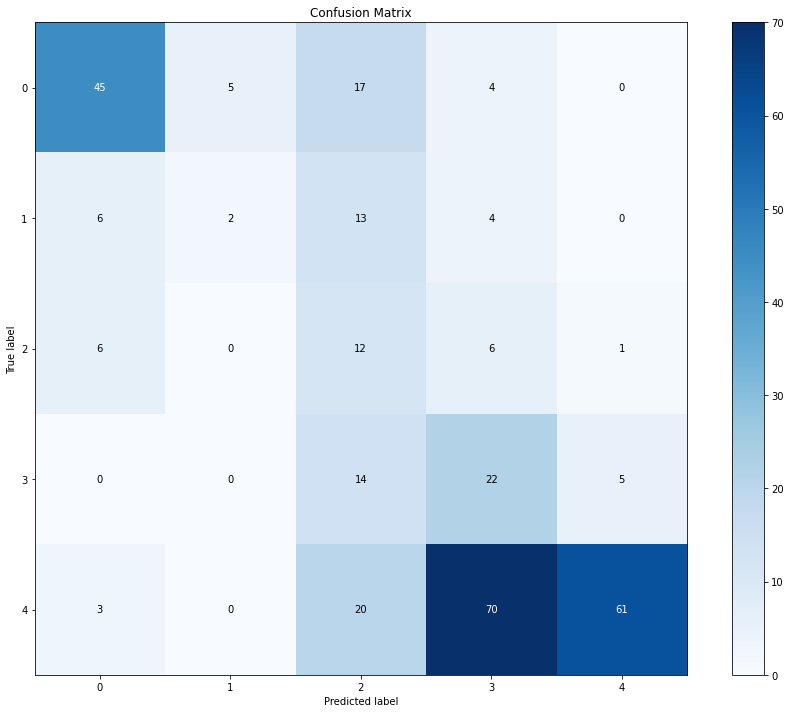

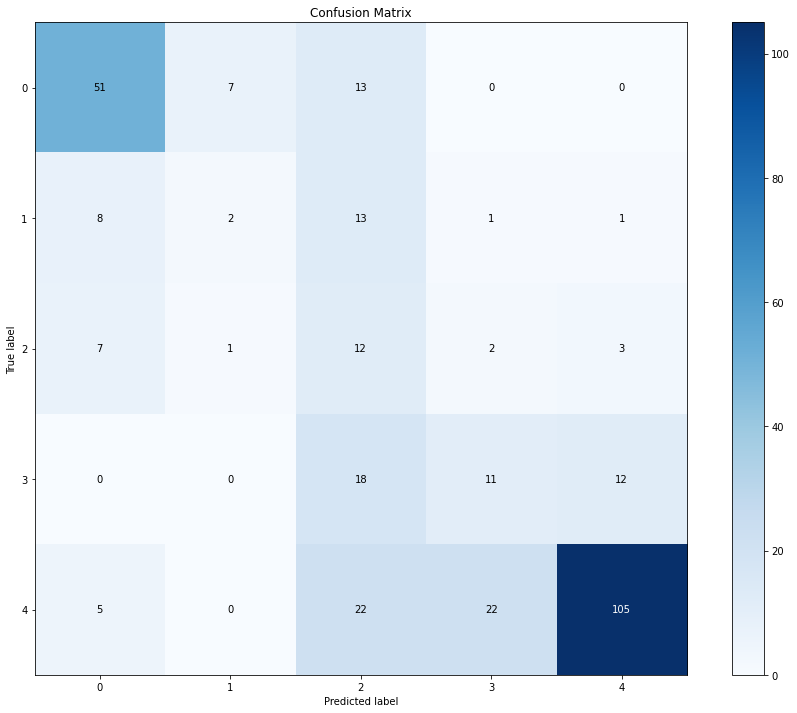

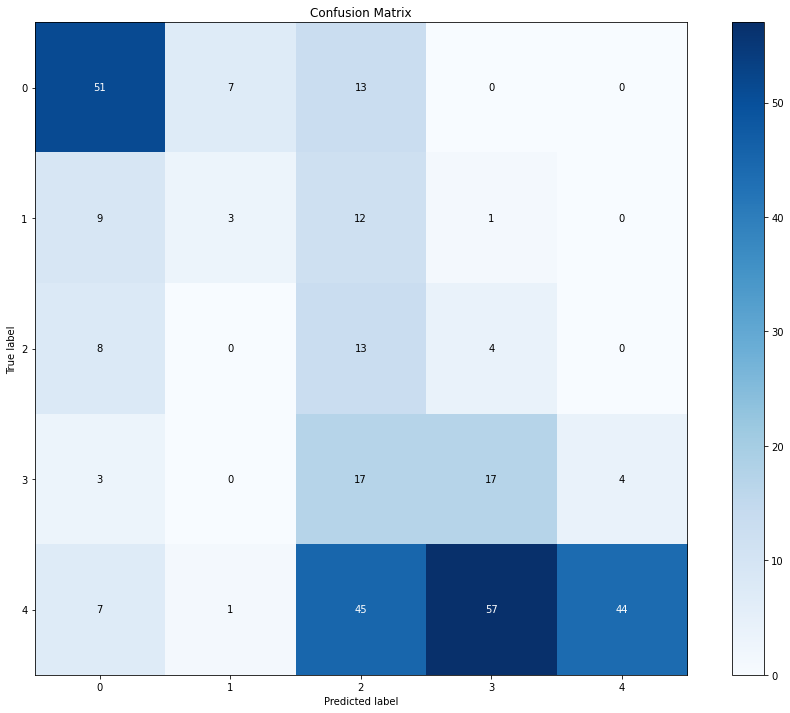

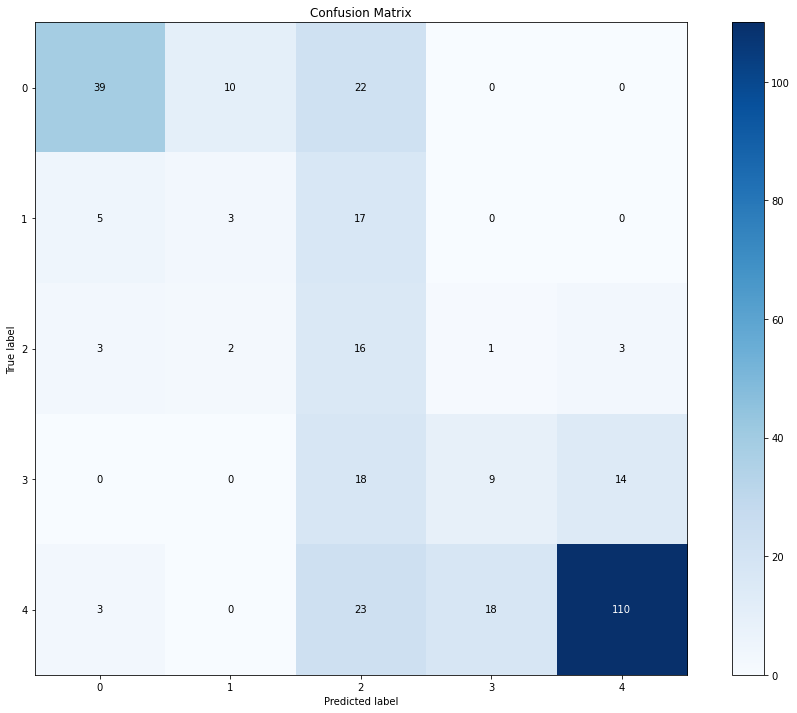

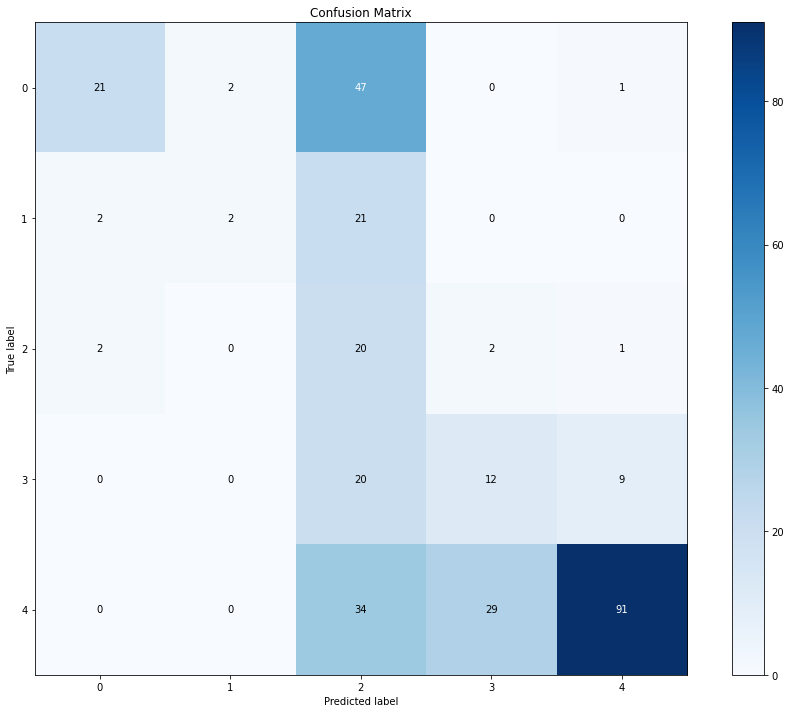

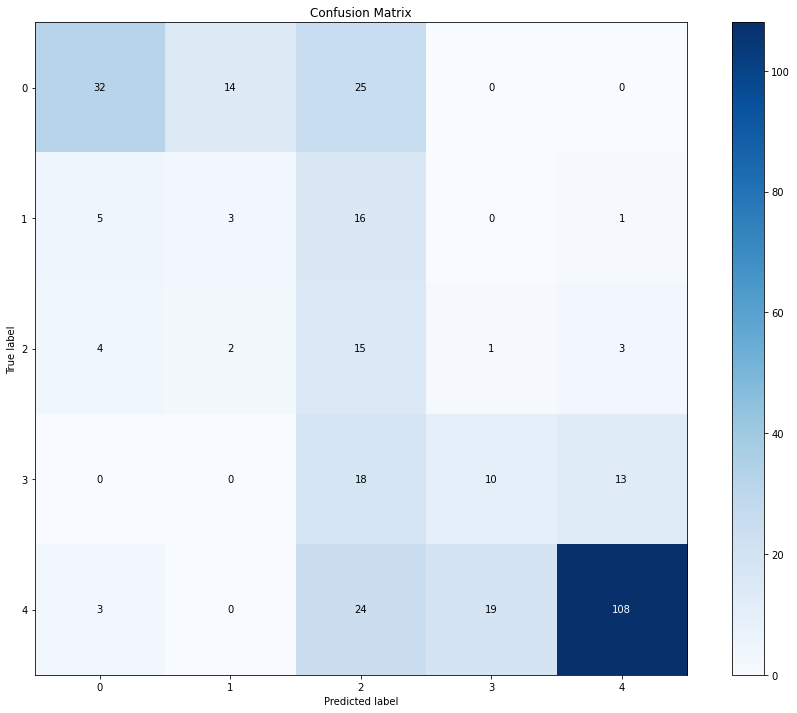

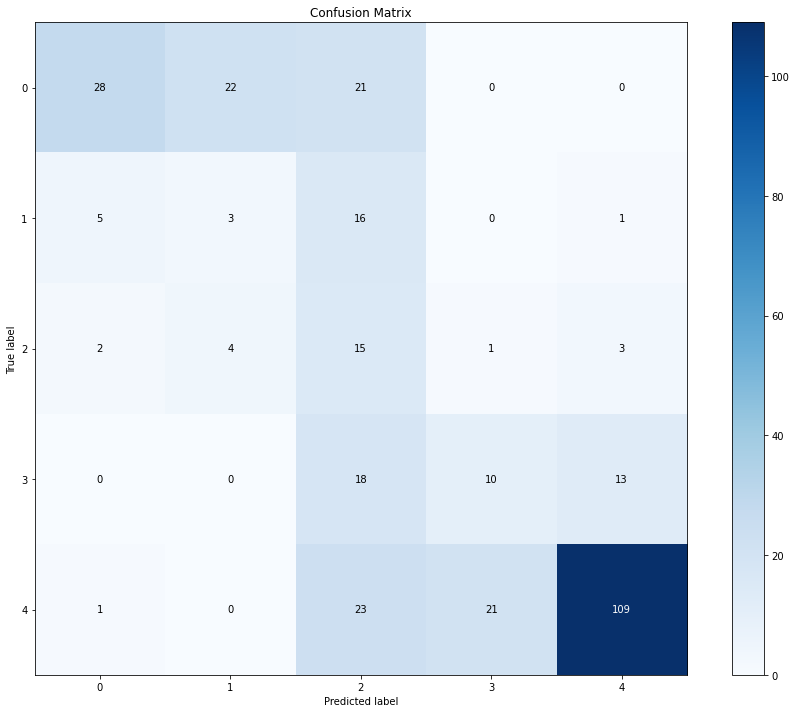

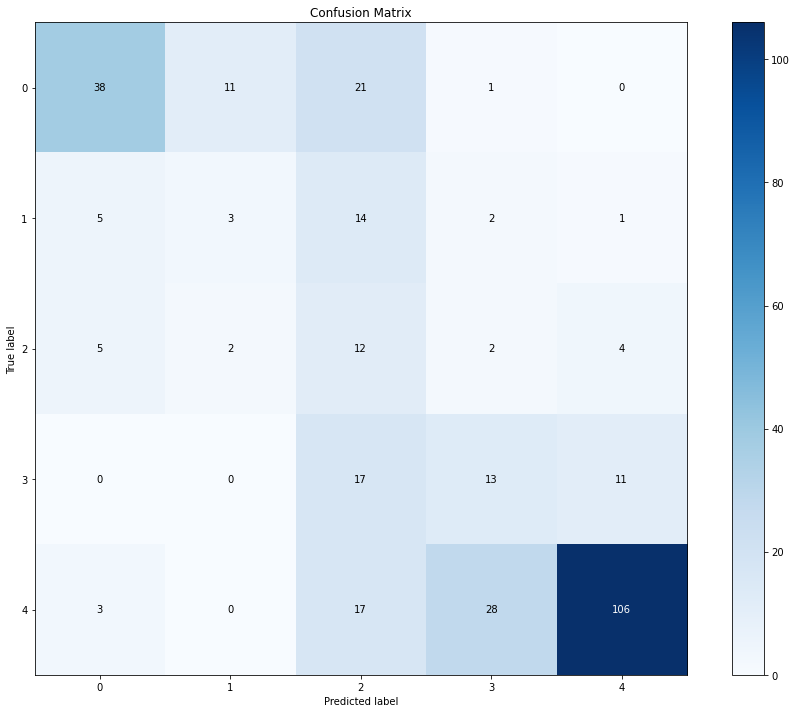

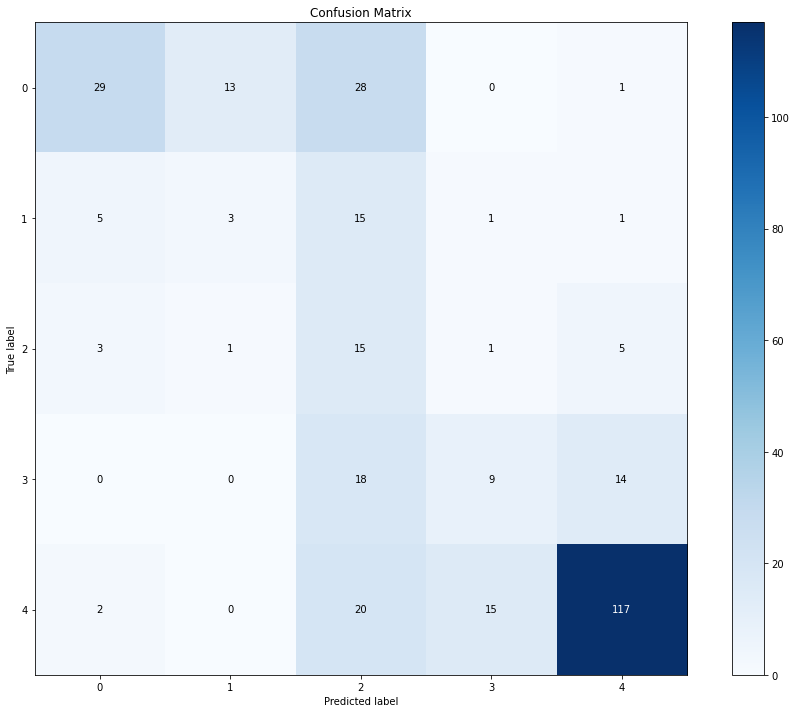

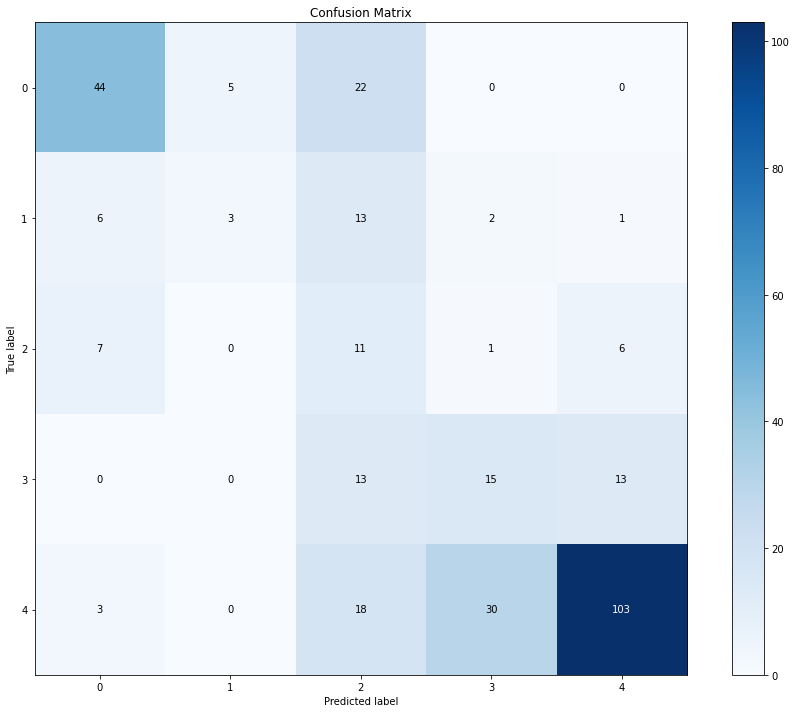

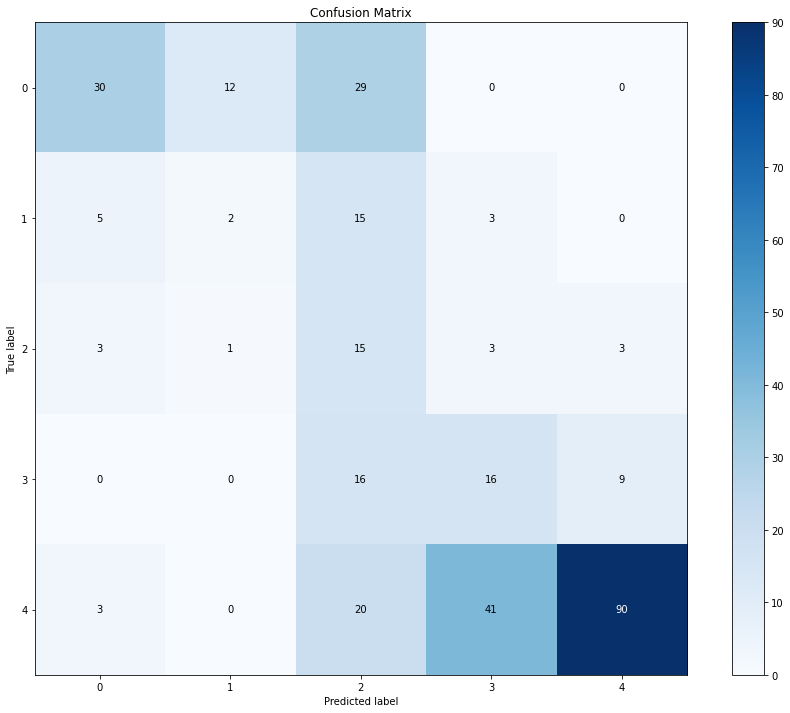

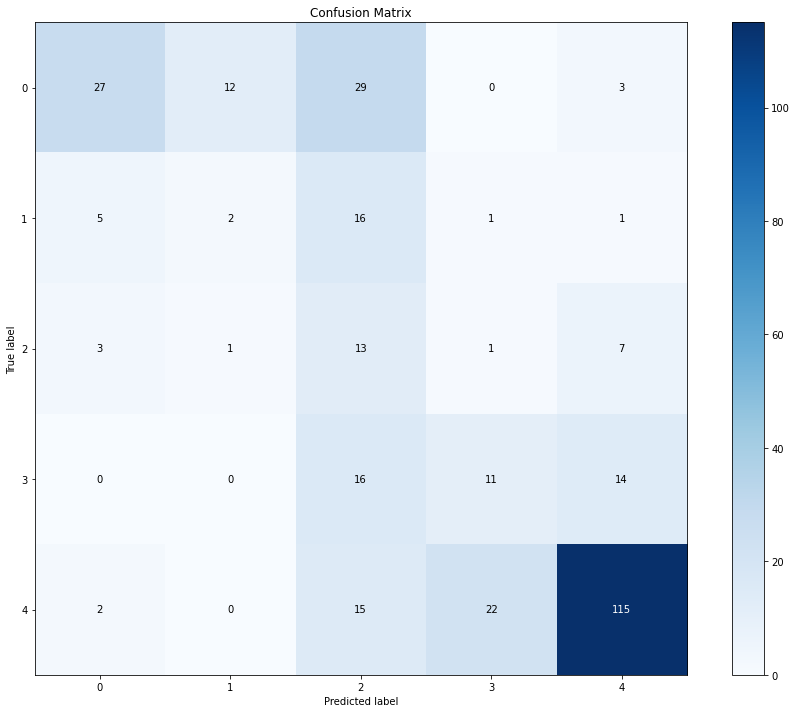

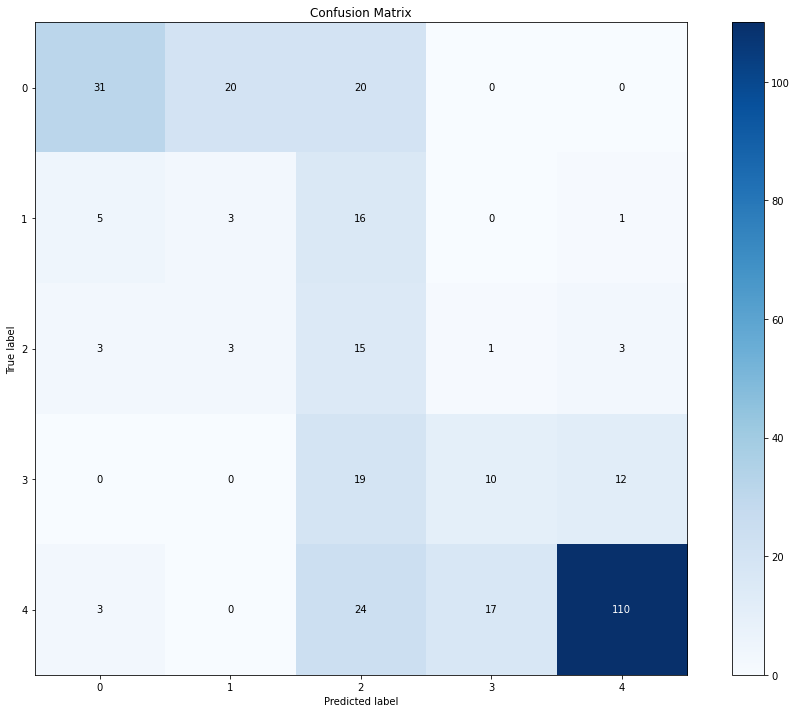

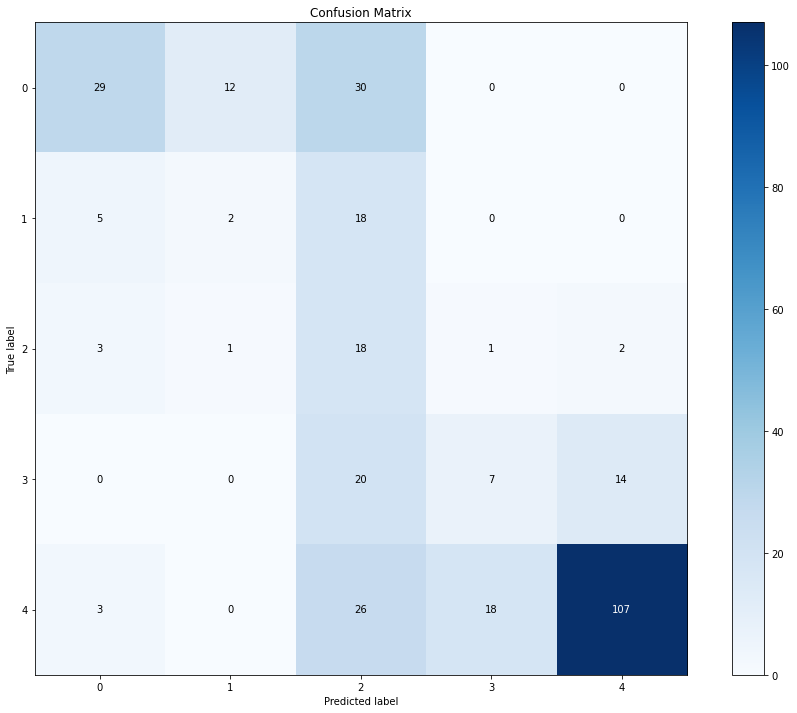

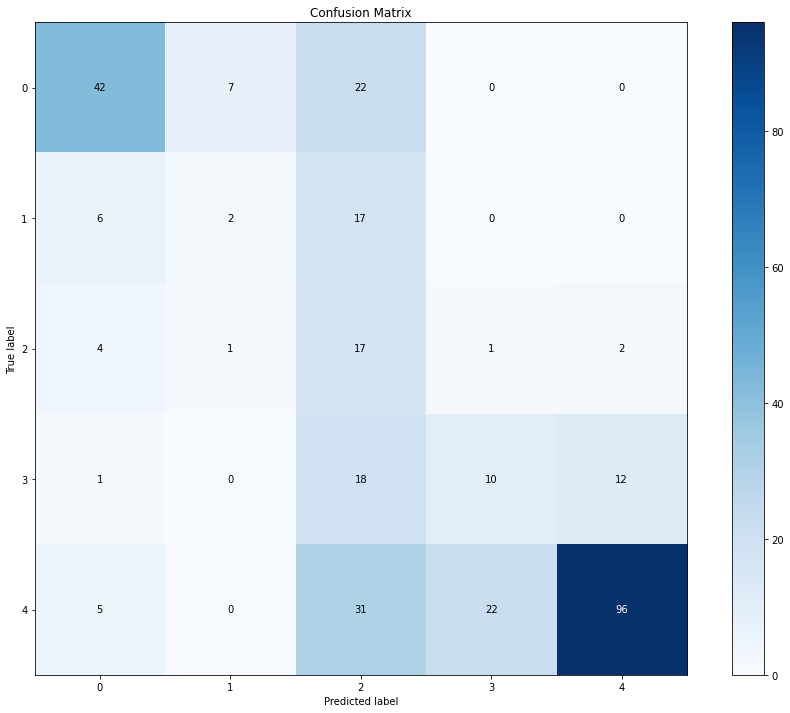

In [67]:
#Fitting the model
history = model.fit(X_train, y_train, batch_size=32, class_weight = class_weights, epochs=20,callbacks=[callback, performance_cbk],validation_data =(X_val, y_val), verbose=1)

In [68]:
#Evaluating the model with the test set
results = model.evaluate(X_test, y_test)

20/20 [==============================] - 1s 39ms/step - loss: 1.6902 - Accuracy: 0.5496


## Point of Data Testing (Unit Testing)

In [72]:
def get_rating(text):
  out=(model.predict([text])).argmax()
  print(model.predict([text]))
  if out==0:
    print("1 star")
  elif out==1:
    print("2 star")
  elif out==2:
    print("3 star")
  elif out==3:
    print("4 star")
  elif out==4:
    print("5 star")

In [73]:
get_rating("Excellent phone")

[[0.10923003 0.09959342 0.24209498 0.22084473 0.32823682]]
5 star


In [74]:
get_rating("The phone is ok")

[[0.09212811 0.11229992 0.26026642 0.31439602 0.22090949]]
4 star


In [75]:
get_rating("The phone is terrible and I hated every bit of it")

[[0.18224084 0.22212039 0.22622143 0.20422697 0.16519041]]
3 star
